# Labeling tools



*   [LabelImg](https://github.com/tzutalin/labelImg)
*   [CVAT](https://github.com/openvinotoolkit/cvat)



# Datasets for object detection

1.   [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)  

2.   [COCO](https://cocodataset.org/)

3.   [Open Images](https://storage.googleapis.com/openimages/web/index.html)


   




# Install dependencies

In [ ]:
!pip install fiftyone==0.14.2 
!pip install ipywidgets>=7.5
!pip install tensorflow torch torchvision umap-learn
!pip install albumentations==1.1.0
!pip install opencv-python==4.5.5.62 
!pip install opencv-python-headless==4.5.4.60

# Load data

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
print(foz.list_zoo_datasets())

In [ ]:
fo.utils.openimages.get_classes(version='v6', dataset_dir=None)

In [ ]:
classes_list = ["Sparrow"]

In [ ]:
sparrow_train_dataset = foz.load_zoo_dataset(
    "open-images-v6", 
    split="train", 
    label_types=["detections"], 
    classes=classes_list,
    max_samples=300,
    seed=51,
    shuffle=True,
    dataset_name="sparrow_train"
)

In [ ]:
sparrow_test_dataset = foz.load_zoo_dataset(
    "open-images-v6", 
    split="test", 
    label_types=["detections"], 
    classes=classes_list,
    max_samples=100,
    seed=51,
    shuffle=True,
    dataset_name="sparrow_test",
)

In [ ]:
sparrow_val_dataset = foz.load_zoo_dataset(
    "open-images-v6", 
    split="validation", 
    label_types=["detections"], 
    classes=classes_list,
    max_samples=100,
    seed=51,
    shuffle=True,
    dataset_name="sparrow_val",
)


In [ ]:
len(sparrow_train_dataset), len(sparrow_test_dataset), len(sparrow_val_dataset)

In [ ]:
session = fo.launch_app(sparrow_train_dataset)

In [ ]:
from fiftyone import ViewField as F

In [ ]:
sparrow_train_dataset = fo.load_dataset("sparrow_train").filter_labels( "detections", (F("label") == "Sparrow"))
sparrow_test_dataset = fo.load_dataset("sparrow_test").filter_labels( "detections", (F("label") == "Sparrow"))
sparrow_val_dataset = fo.load_dataset("sparrow_val").filter_labels( "detections", (F("label") == "Sparrow"))

## Closer look at sample

In [ ]:
img_path = sparrow_train_dataset.values("filepath")[42]
sample = sparrow_train_dataset[img_path]
sample

In [ ]:
detections = sample["detections"].detections
detections

# Prepare Dataset class

In [ ]:
import torch
import cv2

torch.manual_seed(42)

In [ ]:

class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.
    
    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the 
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="detections",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        # reading the images and converting them to correct color  
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # prepairing target
        sample = self.samples[img_path]   
        # cv2 image gives size as height x width    
        wt = img.shape[1]
        ht = img.shape[0]

        boxes = []
        labels = []

        detections = sample[self.gt_field].detections
        for det in detections:
            if det.label not in self.classes:
                continue
                
            category_id = self.labels_map_rev[det.label]
            x, y, w, h = det["bounding_box"]
            boxes.append([x * wt, y * ht, (x + w) * wt, (y + h) * ht])
            labels.append(category_id)

        
        # applying augmentations
        if self.transforms is not None:
            transformed = self.transforms(image=img,bboxes=boxes, category_ids=labels)
            img = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["category_ids"]

        # convert boxes into a torch.Tensor                
        boxes = torch.as_tensor(boxes, dtype=torch.float32)                
            
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])

        # getting the areas of the boxes
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

# Augmentations

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
train_transform = A.Compose(
    [
        A.LongestMaxSize(320),
        A.PadIfNeeded(min_height=320, min_width=320, border_mode=0),
        A.RandomSizedBBoxSafeCrop(width=300, height=300, erosion_rate=0.1),
     
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.3),
        A.ToFloat(max_value=255, p=1, always_apply=True),

        ToTensorV2(p=1.0)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

test_transform = A.Compose(
    [
        A.LongestMaxSize(300),
        A.PadIfNeeded(min_height=300, min_width=300, border_mode=0),
        A.ToFloat(max_value=255, p=1, always_apply=True),

        ToTensorV2(p=1.0)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

In [ ]:
torch_dataset = FiftyOneTorchDataset(sparrow_train_dataset, train_transform, 
        classes=classes_list, gt_field="detections")
torch_dataset_test = FiftyOneTorchDataset(sparrow_test_dataset, test_transform, 
        classes=classes_list, gt_field="detections")

# Visualization

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""

    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.permute(1, 2, 0).numpy() if type(image) is torch.Tensor else image.copy()
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id.item()]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
category_id_to_name = {i: c for i, c in enumerate(torch_dataset.get_classes())}
category_id_to_name

In [ ]:
img, target = torch_dataset[42]
visualize(
    img,
    target['boxes'],
    target['labels'],
    category_id_to_name,
)

In [ ]:
img, target = torch_dataset_test[42]
visualize(
    img,
    target['boxes'],
    target['labels'],
    category_id_to_name,
)

# Training

In [ ]:
# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./



In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
import torchvision
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)

[SSD paper](https://arxiv.org/abs/1512.02325)

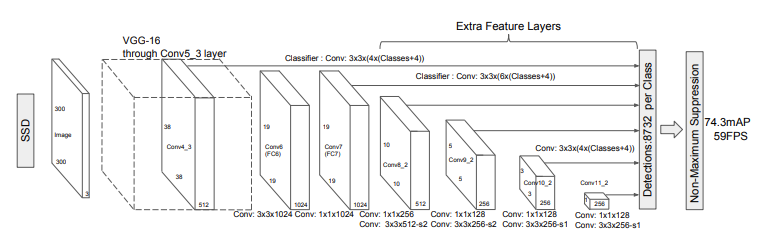

In [ ]:
model

In [ ]:
from torchvision.models.detection.ssd import SSDHead
head = SSDHead(in_channels=[512, 1024, 512, 256, 256, 256] , num_anchors=[4,6,6,6,4,4] , num_classes=2)
model.head = head

In [ ]:
model

[Source code of SSD](https://pytorch.org/vision/master/_modules/torchvision/models/detection/ssd.html)

In [ ]:
bs = 2
test_bs = 1
num_epochs = 10
learning_rate = 0.0005

In [ ]:
data_loader = torch.utils.data.DataLoader(
    torch_dataset, batch_size=bs, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    torch_dataset_test, batch_size=test_bs, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device %s" % device)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

# Evaluating

In [ ]:
import fiftyone.utils.coco as fouc

def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
    # Convert the outputs of the torch model into a FiftyOne Detections object
    dets = []
    scale = max(w, h)
    shift = abs(w - h) / 2
    if w > h:
        shift = np.tile([0,1], 2) * shift
    else:
        shift = np.tile([1,0], 2) * shift
        
    for bbox, label, score in zip(
        preds["boxes"].cpu().detach().numpy(), 
        preds["labels"].cpu().detach().numpy(), 
        preds["scores"].cpu().detach().numpy()
    ):

        # Parse prediction into FiftyOne Detection object
        x0, y0, x1, y1 = bbox / 300 * scale - shift
        coco_obj = fouc.COCOObject(det_id, s_id, int(label), [x0, y0, x1-x0, y1-y0])
        det = coco_obj.to_detection((w,h), classes)
        det["confidence"] = float(score)
        dets.append(det)
        det_id += 1
        
    detections = fo.Detections(detections=dets)
        
    return detections, det_id

def add_detections(model, torch_dataset, view, field_name="predictions"):
    # Run inference on a dataset and add results to FiftyOne
    torch.set_num_threads(1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    model.eval()
    model.to(device)
    image_paths = torch_dataset.img_paths
    classes = torch_dataset.classes
    det_id = 0
    
    with fo.ProgressBar() as pb:
        for img, targets in pb(torch_dataset):
            # Get FiftyOne sample indexed by unique image filepath
            img_id = int(targets["image_id"][0])
            img_path = image_paths[img_id]
            sample = view[img_path]
            s_id = sample.id
            w, h = 0, 0
            if sample.metadata is None:
                img_raw = cv2.imread(img_path)
                h, w, _ = img_raw.shape
            else:
                w = sample.metadata["width"]
                h = sample.metadata["height"]
            
            # Inference
            preds = model(img.unsqueeze(0).to(device))[0]
            
            detections, det_id = convert_torch_predictions(
                preds, 
                det_id, 
                s_id, 
                w, 
                h, 
                classes,
            )
            
            sample[field_name] = detections
            sample.save()

In [ ]:
torch_dataset_val = FiftyOneTorchDataset(sparrow_val_dataset, test_transform, 
        classes=classes_list, gt_field="detections")

In [ ]:
add_detections(model, torch_dataset_val, sparrow_val_dataset, field_name="predictions")

In [ ]:
metric_view = sparrow_val_dataset.filter_labels("predictions", F("confidence") > 0.5)

In [ ]:
results = fo.evaluate_detections(
    metric_view,
    "predictions",
    gt_field="detections", 
    classes=["Sparrow"], 
    eval_key="eval", 
    compute_mAP=True
)

In [ ]:
results.mAP(), results.metrics() 

In [ ]:
results.plot_pr_curves(backend='matplotlib')

In [ ]:
session = fo.launch_app(metric_view)

In [ ]:
torch.save(model.state_dict(), "ssd300_sparrow_10epochs.pth")